# College Message Dataset

- https://snap.stanford.edu/data/CollegeMsg.html
- https://toreopsahl.com/datasets/#online_social_network

## Reading Data

In [160]:
!pip install networkx matplotlib scipy

In [161]:
from typing import NamedTuple
class CollegeMessage(NamedTuple):
    source: int #source id
    target: int # target id
    unix_timestamp: int # seconds after last epoc

Data is stored in a text file with each line containing the source id, target id and the timestamp of the message.

In [162]:
from pathlib import Path
def read_message_data(data_path: str) -> list[CollegeMessage]:

    filepath = Path.cwd() / Path(data_path)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(data_path)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


In [163]:
data_path = "./dataset/CollegeMsg.txt"

MESSAGES = read_message_data(data_path)

Using file: C:\Users\Gebruiker_\studie\SNA\dataset\CollegeMsg.txt
done


Taking a first glance at raw data in a pandas dataframe

In [164]:
import pandas as pd
raw_data_df = pd.DataFrame(MESSAGES)
raw_data_df.head()


,source,target,unix_timestamp
0,1,2,1082040961
1,3,4,1082155839
2,5,2,1082414391
3,6,7,1082439619
4,8,7,1082439756


## Data Preprocessing

Here we remove nodes which only send or receive a message

In [165]:
# remove nodes with in or out degree of <= 1
def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]

raw_data_df = remove_low_degree_nodes(raw_data_df, 2)

raw_data_df.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


## Creating the networkx graph

Function to create a graph from the data

In [166]:

import networkx as nx

def create_graph(data: pd.DataFrame ) -> nx.DiGraph:
    G = nx.DiGraph()
    for row in data.itertuples(index=False):
        G.add_edge(row.source, row.target, timestamp=row.unix_timestamp)
    return G


Create the graph

In [167]:
raw_data_graph = create_graph(raw_data_df)

Draw the graph (uncomment if necessary)

In [168]:
import matplotlib.pyplot as plt

def draw_graph(graph: nx.DiGraph):
    plt.figure(figsize=(10, 10))
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)
    plt.show()

# draw_graph(raw_data_graph)

# 1. Network Metrics

In [169]:
def calculate_metrics(graph: nx.DiGraph):
    metrics = {}
    metrics["number_of_nodes"] = graph.number_of_nodes()
    metrics["number_of_edges"] = graph.number_of_edges()
    metrics["degree_distribution"] = {
        "in_degree": dict(graph.in_degree()),
        "out_degree": dict(graph.out_degree())
    }
    metrics["centrality"] = {
        "in_degree": nx.in_degree_centrality(graph),
        "out_degree": nx.out_degree_centrality(graph),
        "closeness": nx.closeness_centrality(graph),
        "betweenness": nx.betweenness_centrality(graph),
        "eigenvector": nx.eigenvector_centrality(graph)
    }
    metrics["clustering_coefficient"] = nx.average_clustering(graph)
    try:
        metrics["diameter"] = nx.diameter(graph.to_undirected())
    except nx.NetworkXError:
        # Handle the case where the graph is not connected
        metrics["diameter"] = float('inf')  # or any other value to indicate
    metrics["density"] = nx.density(graph)
    metrics["connected_components"] = {
        "number": nx.number_connected_components(graph.to_undirected()),
        "sizes": [len(c) for c in nx.connected_components(graph.to_undirected())]
    }
    return metrics

run metric calculation

In [170]:
raw_data_metrics = calculate_metrics(raw_data_graph)

Extract the numerical metrics that are not distributions into a csv file

In [171]:
def extract_numerical_metrics(metrics: dict, output_path: str):
    numerical_metrics = {
        "number_of_nodes": metrics["number_of_nodes"],
        "number_of_edges": metrics["number_of_edges"],
        "clustering_coefficient": metrics["clustering_coefficient"],
        "diameter": metrics["diameter"],
        "density": metrics["density"],
        "number_of_connected_components": metrics["connected_components"]["number"],
        "average_connected_component_size": sum(metrics["connected_components"]["sizes"]) / len(metrics["connected_components"]["sizes"])
    }
    df = pd.DataFrame([numerical_metrics])
    df.to_csv(output_path, index=False)
    
numerical_metrics_path = "./numerical_metrics.csv"
extract_numerical_metrics(raw_data_metrics, numerical_metrics_path)


## Visualizing the metrics

### Number of nodes and edges

In [172]:
print(f"Number of nodes: {raw_data_metrics['number_of_nodes']}")
print(f"Number of edges: {raw_data_metrics['number_of_edges']}")

Number of nodes: 1132
Number of edges: 18436


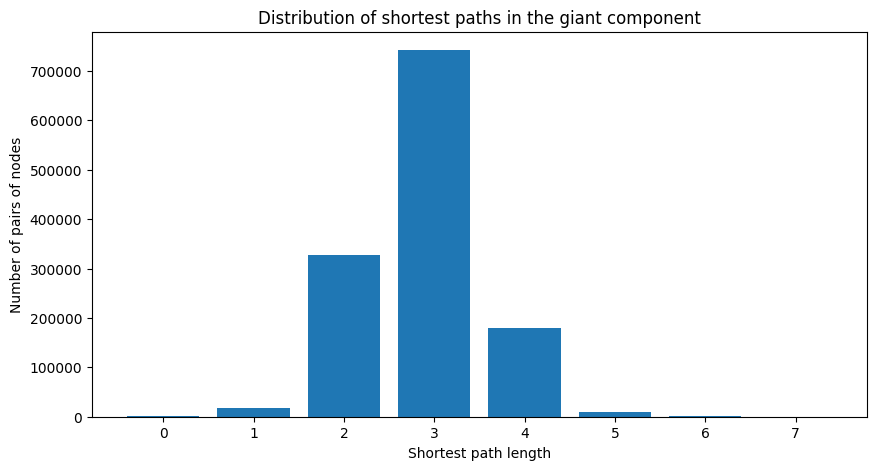

Maximum shortest path length: 7
Minimum shortest path length: 0


In [84]:
from collections import Counter


def kevin_bacon():
    # Identify the giant component, leaving only it in the (copied) graph
    giant_component = max(nx.connected_components(raw_data_graph.to_undirected()), key=len)
    giant_graph = raw_data_graph.subgraph(giant_component)

    # Find the shortest path between all pairs of nodes
    shortest_paths = dict(nx.all_pairs_shortest_path_length(giant_graph))

    # Create a distribution graph showing count of each length
    counts = Counter(
        length
        for lengths in shortest_paths.values()
        for length in lengths.values()
    )

    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title("Distribution of shortest paths in the giant component")
    plt.xlabel("Shortest path length")
    plt.ylabel("Number of pairs of nodes")
    plt.show()

    # print statistics of the shortest paths
    print(f"Maximum shortest path length: {max(counts.keys())}")
    print(f"Minimum shortest path length: {min(counts.keys())}")

kevin_bacon()

# 2. Communities
## Identify groups and their structure
Identify:
▪ Cliques
▪ Important nodes acting as Bridges
▪ Partitioning Algorithm: Girvan-Newman

In [85]:
raw_data_groups = {}
all_cliques = list(nx.find_cliques(raw_data_graph.to_undirected()))
all_bridges = list(nx.bridges(raw_data_graph.to_undirected()))

In [86]:
print(f'Number of cliques is: {len(all_cliques)}')
print(f'Number of bridges is: {len(all_bridges)}')

Number of cliques is: 10963
Number of bridges is: 9


### Visualize cliques

C:\Users\Gebruiker_\AppData\Local\Temp\ipykernel_7328\2806690553.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 10)  # Get a colormap with 10 unique colors


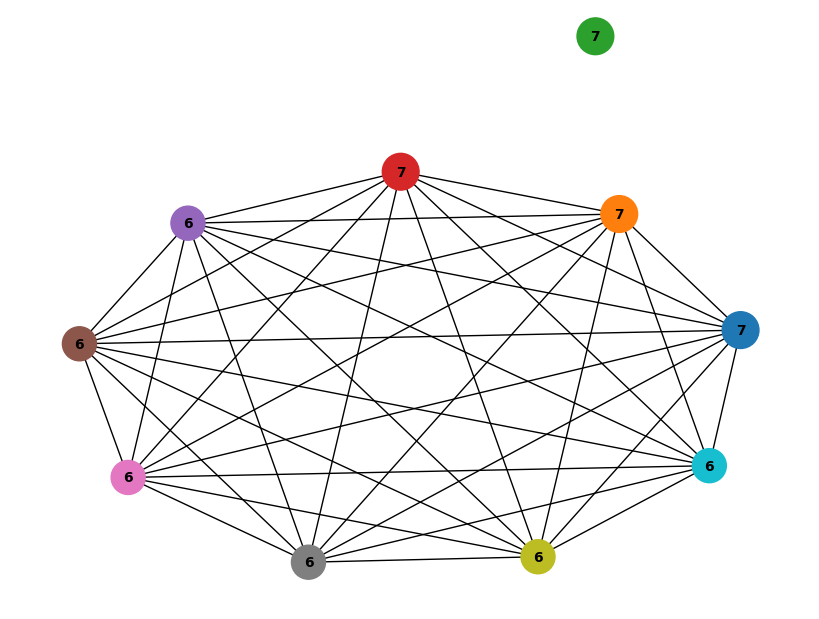

In [109]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import numpy as np

shared_nodes_limit = 1  # Set your desired shared nodes limit here

# Assuming undirected graph for cliques
undirected_graph = raw_data_graph.to_undirected()

# Step 1: Find and sort all cliques by size, then take the 10 largest
max_cliques = list(nx.find_cliques(undirected_graph))
sorted_cliques = sorted(max_cliques, key=len, reverse=True)
top_10_cliques = sorted_cliques[:10]

# Step 2: Create a new graph where each clique is a node
clique_graph = nx.Graph()

# Add each clique as a single node with the clique size as an attribute
for i in range(10):
    clique_graph.add_node(i, size=len(top_10_cliques[i]))

# Add edges between clique nodes if they have at least `shared_nodes_limit` shared members
for i in range(10):
    for j in range(i + 1, 10):
        # Check if cliques i and j have at least `shared_nodes_limit` shared nodes
        shared_nodes = set(top_10_cliques[i]).intersection(top_10_cliques[j])
        if len(shared_nodes) >= shared_nodes_limit:
            clique_graph.add_edge(i, j)

# Step 3: Prepare labels based on clique size
labels = {i: len(top_10_cliques[i]) for i in range(10)}  # Labels are the sizes of the cliques

# Set up node sizes proportional to the clique sizes for better visualization
node_sizes = [len(clique) * 100 for clique in top_10_cliques]  # Scale up for visibility

# Generate a unique color for each node
colors = cm.get_cmap('tab10', 10)  # Get a colormap with 10 unique colors
node_colors = [colors(i) for i in range(10)]  # Assign a unique color to each node

# Position layout for better spacing
pos = nx.kamada_kawai_layout(clique_graph)

# Draw the clique graph with labels showing clique sizes and unique colors for each node
plt.figure(figsize=(8, 6))
nx.draw(clique_graph, pos, with_labels=True, labels=labels, node_size=node_sizes,
        node_color=node_colors, font_size=10, font_weight="bold")
plt.show()


### Calculate clique metrics

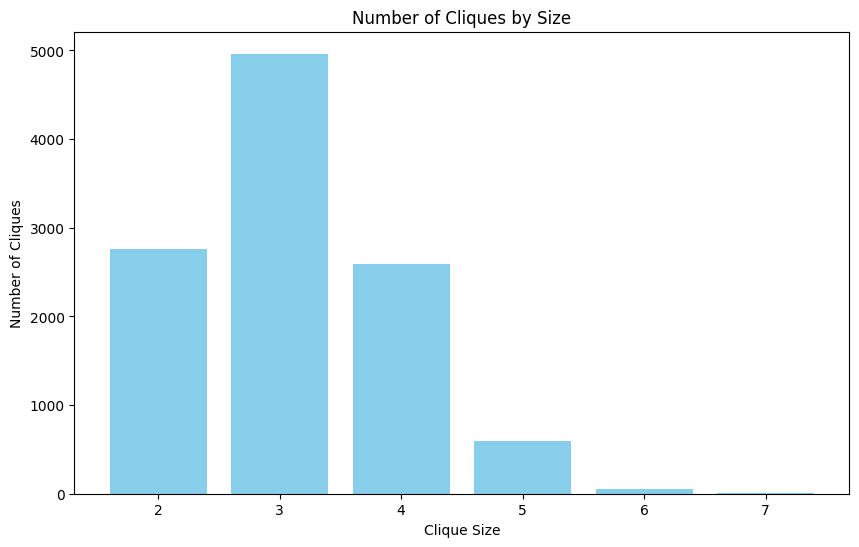

Clique Number (size of largest clique): 7
Clique Cover Number (minimum number of cliques to cover all nodes): 1028


In [107]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Convert the directed graph to an undirected version for clique analysis
undirected_graph = raw_data_graph.to_undirected()

# Find all cliques
max_cliques = list(nx.find_cliques(undirected_graph))

# Step 2: Count cliques by size
clique_sizes = {}
for clique in max_cliques:
    size = len(clique)
    if size not in clique_sizes:
        clique_sizes[size] = 0
    clique_sizes[size] += 1

# Plotting the number of cliques by size
sizes = sorted(clique_sizes.keys())
counts = [clique_sizes[size] for size in sizes]

plt.figure(figsize=(10, 6))
plt.bar(sizes, counts, color='skyblue')
plt.xlabel("Clique Size")
plt.ylabel("Number of Cliques")
plt.title("Number of Cliques by Size")
plt.xticks(sizes)
plt.show()

# Step 4: Examine the Clique Number and the Clique Cover Number
# Clique Number
clique_number = max(len(clique) for clique in max_cliques)

# Clique Cover Number
# Approximating minimum number of cliques to cover all nodes
nodes_covered = set()
clique_cover = []
for clique in sorted(max_cliques, key=len, reverse=True):
    if not nodes_covered.issuperset(clique):
        clique_cover.append(clique)
        nodes_covered.update(clique)

clique_cover_number = len(clique_cover)

# Display results
print("Clique Number (size of largest clique):", clique_number)
print("Clique Cover Number (minimum number of cliques to cover all nodes):", clique_cover_number)


### Visualize the bridges

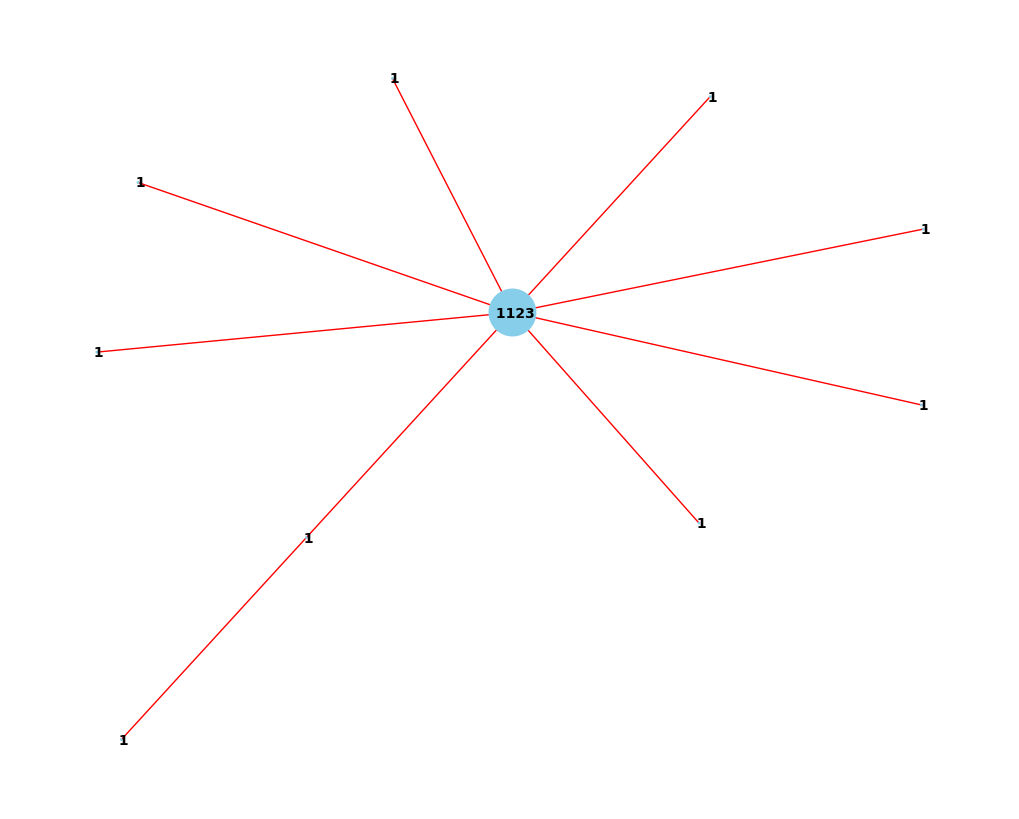

In [124]:
import matplotlib.pyplot as plt
import networkx as nx

# If 'raw_data_graph' is already an undirected graph, you can skip the conversion
undirected_graph = raw_data_graph.to_undirected()

# Step 1: Find all bridges in the graph
bridges = list(nx.bridges(undirected_graph))

# Step 2: Remove all bridges to find clusters (bridge-connected components)
undirected_graph.remove_edges_from(bridges)

# Find connected components after removing bridges
components = list(nx.connected_components(undirected_graph))

# Step 3: Map each node to its cluster index
node_to_cluster = {}
for idx, component in enumerate(components):
    for node in component:
        node_to_cluster[node] = idx

# Step 4: Create a new graph to represent clusters as nodes and bridges as edges
cluster_graph = nx.Graph()

# Add nodes to 'cluster_graph' with cluster sizes as node attributes
for idx, component in enumerate(components):
    cluster_graph.add_node(idx, size=len(component))

# Add edges between clusters based on bridges
for u, v in bridges:
    c1 = node_to_cluster[u]
    c2 = node_to_cluster[v]
    if c1 != c2:
        cluster_graph.add_edge(c1, c2)

# Prepare labels showing the cluster size for each node
node_labels = {node: f" {data['size']}" for node, data in cluster_graph.nodes(data=True)}

# Visualization
pos = nx.kamada_kawai_layout(cluster_graph)  # Fixed seed for consistent layout
plt.figure(figsize=(10, 8))

# Draw the cluster graph with node labels showing cluster sizes
nx.draw(
    cluster_graph,
    pos,
    with_labels=True,
    labels=node_labels,
    node_color="skyblue",
    edge_color="red",
    font_size=10,
    font_weight="bold",
    node_size=[data['size'] * 1 for _, data in cluster_graph.nodes(data=True)]
)

plt.show()


### HITS

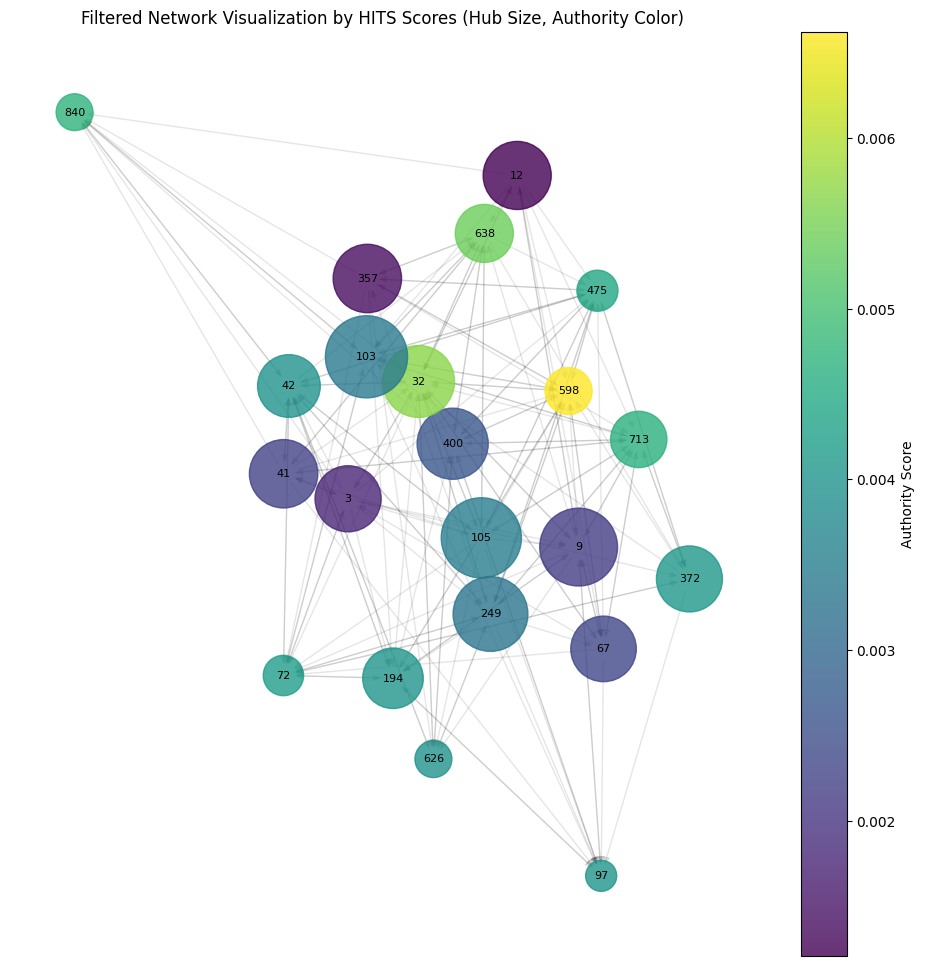

In [194]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = raw_data_graph
# Calculate hub and authority scores
hub_scores, authority_scores = nx.hits(G)

# Assign hub and authority scores to each node in the graph
for node in G.nodes():
    G.nodes[node]['hub_score'] = hub_scores[node]
    G.nodes[node]['authority_score'] = authority_scores[node]

# Define thresholds for top 1% based on hub or authority scores
hub_threshold = sorted(hub_scores.values(), reverse=True)[int(len(hub_scores) * 0.01)]
authority_threshold = sorted(authority_scores.values(), reverse=True)[int(len(authority_scores) * 0.01)]

# Filter nodes that meet the hub or authority threshold
filtered_nodes = [node for node in G.nodes() if G.nodes[node]['hub_score'] >= hub_threshold or
                  G.nodes[node]['authority_score'] >= authority_threshold]

# Create a subgraph with the filtered nodes
filtered_subgraph = G.subgraph(filtered_nodes)

# Set up plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(filtered_subgraph, seed=42)  # Force-directed layout

# Normalize hub scores for node size scaling
hub_values = np.array([filtered_subgraph.nodes[node]['hub_score'] for node in filtered_subgraph])
min_hub, max_hub = hub_values.min(), hub_values.max()
node_sizes = [500 + 3000 * (filtered_subgraph.nodes[node]['hub_score'] - min_hub) / (max_hub - min_hub)
              for node in filtered_subgraph]  # Scale sizes for visibility

# Use authority scores directly for color mapping
authority_values = np.array([filtered_subgraph.nodes[node]['authority_score'] for node in filtered_subgraph])

# Draw nodes with size based on hub score and color based on authority score
nodes = nx.draw_networkx_nodes(
    filtered_subgraph,
    pos,
    node_size=node_sizes,
    node_color=authority_values,
    cmap='viridis',
    alpha=0.8
)

# Draw edges with transparency
nx.draw_networkx_edges(filtered_subgraph, pos, alpha=0.1)

# Use node names as labels
nx.draw_networkx_labels(filtered_subgraph, pos, labels={node: node for node in filtered_subgraph}, font_size=8)

# Add a color bar for the authority score
plt.colorbar(nodes, label="Authority Score")  # Link color bar directly to drawn nodes

# Title and display
plt.title("Filtered Network Visualization by HITS Scores (Hub Size, Authority Color)")
plt.axis("off")
plt.show()
